# Faltungsnetz Versuch 4: Unterschiedliche Strecken

## Einleitung

In diesen Versuch werden Faltungsnetze mit den Daten aus dem Datensatz 37 bis 42 trainiert. Die Daten wurden auf unterschiedlichen Routen erfasst. Beim Start und Ende der Datenerfassung zu einer Strecke überschneiden sich einige befahrene Wege. Diese Wege wurden also mehr als einmal befahren. Gelabelt wurden die Daten mit Fuzzy-Logik (siehe Notebook daten_labeln/fuzzyLogic.ipynb). Zum Trainieren des Netzes ist es nötig das nur ein Teil der Bilder in den Hauptspeicher geladen wird, weil ansonsten der Speicherplatz nicht ausreicht bei 8GB RAM. Dafür wird die Keras Methode fit_generator() genutzt mit welchem eine Generator Methode Implementiert werden kann, welche so viele Bilder in der Anzahl der batch size (Stapelgröße) läd für einen Trainingsschritt.     

### Versuch 4.1 Versuchsbeschreibung: Unterteilung der Fahrqualität in 4 Klassen

Die Trainingsdaten wurden klassifiziert in 4 Klassen nach der Fahrqualität. Für weitere Informationen zur Einordnung der Daten siehe Fuzzy Logik Versuch 2. Als Parameter für das Faltungsnetz wird als Vorlage das Model aus Faltungsnetz Versuch 1.9 genutzt.

### Versuch 4.1 Ergebnis:




### Versuch 4.2 Versuchbeschreibung: Hypertuning


### Ergebnisse

Versuch Nr. | validierungs Accuracy | validierungs Loss | Trainings Accuracy | Trainings Loss |  
--- | --- | --- | --- | --- |
4.1 | 0.7705 | 0.4947 | 0.7644 | 0.5073 |
Tabelle 1: Ergebnisse der Versuche

In [1]:
import pandas
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os
import cv2
import numpy as np

In [2]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.models import load_model
import keras.callbacks as cb
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

C:\Users\user\AppData\Local\conda\conda\envs\bicycle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
featuresDf = pandas.read_csv(filepath_or_buffer="../daten/merkmale_datensatz_37_bis_42/merkmaleMitLabeln.csv")

In [4]:
# Nummer des aktuellen Versuchs
experimentNumber = "1"

In [5]:
# Hier können die Datensätze ausgewählt werden
datasets = ['37','38','39','40','41','42']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []
# Liste mit Pfaden zu den Bildern
imagePaths = []

In [6]:
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("C:/Users/morro/Documents/datenRoh/" + dataset + "/zugeschnitten/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    folders = sorted(folders, key=int) #sortiert die Reihenfolge de Ordner aufsteifend
    print(path)
    print("Bilder aus folgenden Ordnern werden geladen: " + str(folders))
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        files = os.listdir(filesPath)
        print("Ordner der geladen wird: " + str(folder))
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            imagePaths.append(filesPath + name)

C:/Users/morro/Documents/datenRoh/37/zugeschnitten/
Bilder aus folgenden Ordnern werden geladen: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
Ordner der geladen wird: 1
Ordner der geladen wird: 2
Ordner der geladen wird: 3
Ordner der geladen wird: 4
Ordner der geladen wird: 5
Ordner der geladen wird: 6
Ordner der geladen wird: 7
Ordner der geladen wird: 8
Ordner der geladen wird: 9
Ordner der geladen wird: 10
Ordner der geladen wird: 11
Ordner der geladen wird: 12
Ordner der geladen wird: 13
Ordner der geladen wird: 14
C:/Users/morro/Documents/datenRoh/38/zugeschnitten/
Bilder aus folgenden Ordnern werden geladen: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
Ordner der geladen wird: 1
Ordner der geladen wird: 2
Ordner der geladen wird: 3
Ordner der geladen wird: 4
Ordner der geladen wird: 5
Ordner der geladen wird: 6
Ordner der geladen wird: 7
Ordner der geladen wird: 8
Ordner 

In [7]:
imagesNp          = np.array(0) # soll Bilder als numpy Array halten
numberOfChannels  = 3           # Anzahl der Farbkanäle
numberOfClasses   = 4           # Anzahl der Klassen
classNames = ['sehr gut','gut','schlecht','sehr schlecht'] # Namen der Klassen
yLabels           = np.array(0) # Labels / Klassen zuordnung
yShuffle          = np.array(0) # Labels mit der Methode shuffle() vermischt 
xShuffle          = np.array(0) # Bilder zum trainieren mit shuffle() vermischt
xTrain            = np.array(0) # Trainingsdaten (Bilder) 
xTest             = np.array(0) # Testdaten (Bilder)
yTrain            = np.array(0) # Klassen zuordnungen (Labels) für xTrain
yTest             = np.array(0) # Klassen zuordnung (Lables) für xTest

In [8]:
yLabels = np_utils.to_categorical(featuresDf['Klasse'], 0)

In [9]:
# Setzten des RandomState um reproduzierbare Ergebnisse zu erzielen.
np.random.seed(42)

In [10]:
# Mischen der Trainingsdaten
xShuffle, yShuffle = shuffle(imagePaths,yLabels)
# Aufteilung in Trainings und Testdaten
xTrain, xTest, yTrain, yTest = train_test_split(xShuffle, yShuffle, test_size=0.2)

In [68]:
# Diese Funktion läd Bilder in den Hauptspeicher
# imagesPaths: Liste mit Pfaden zu den Bildern != null
def imageLoader(imagePaths):
    images = []
    for path in imagePaths:
        images.append(cv2.imread(path))
    imagesNp = np.array(images)
    imagesNp = imagesNp.astype('float32')
    # Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
    imagesNp /= 255
    return imagesNp

In [12]:
# Läd Trainingsdaten in batches
def dataLoader(imagePaths, features, batchSize):
    imagesCount= len(imagePaths)  
    while True:
        batchStart = 0
        batchEnd = batchSize
        while batchStart < imagesCount:
            limit = min(batchEnd, imagesCount)
            x = imageLoader(imagePaths[batchStart:limit])
            y = features[batchStart:limit]
            yield (x,y) 
            batchStart += batchSize   
            batchEnd += batchSize

In [12]:
# Parameter für das CNN
inputShape     = (368, 70, 3)      # Eingangs Array-Form 
numNeuronsC1   = 32                # Anzahl der Filter / 1 Faltungsschicht
numNeuronsC2   = 32                # Anzahl der Filter / 2 Faltungsschicht
numNeuronsC3   = 64                # Anzahl der Filter / 3 Faltungsschicht
numNeuronsD1   = 64                # Anzahl der Neuronen des Fully connected layer - vollverbundene Schicht
poolSize       = 2                 # Größe der Pooling-Layer
convKernelSize = 3                 # Größe des Faltungskern n*n

In [13]:
model = Sequential()
model.add(Conv2D(numNeuronsC1, (convKernelSize, convKernelSize), padding='valid',input_shape=inputShape))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.05))

model.add(Conv2D(numNeuronsC2, (convKernelSize, convKernelSize)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.33))
  
model.add(Conv2D(numNeuronsC3, (convKernelSize, convKernelSize)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(poolSize, poolSize)))
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(numNeuronsD1))
model.add(Activation('elu'))
model.add(Dropout(0.46))

model.add(Dense(4))
model.add(Activation('softmax')) 

In [14]:
# Zusammenfassung der Parameter des neuralen Netzes
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 366, 68, 32)       896       
_________________________________________________________________
activation_1 (Activation)    (None, 366, 68, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 183, 34, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 183, 34, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 181, 32, 32)       9248      
_________________________________________________________________
activation_2 (Activation)    (None, 181, 32, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 16, 32)        0         
__________

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [16]:
numEpoch=20
batchSize=32
# Early Stopping unterbricht das Training, wenn nach n Epochen die Kostenfunktion nicht weiter minimiert werden konnte 
earlyStopping = cb.EarlyStopping(monitor='val_acc', patience=1000, verbose=0, mode='max')   
# Speichert das beste Modell mit der höhsten Test Accuracy ab
checkpointSafe = cb.ModelCheckpoint('ergebnisse_versuch4/modell_versuch4_' + experimentNumber, monitor='val_acc', save_best_only=True)
hist = model.fit_generator(dataLoader(xTrain, yTrain, batchSize), epochs=numEpoch, steps_per_epoch=(int(len(imagePaths)/batchSize)),
              validation_data=dataLoader(xTest, yTest, batchSize), validation_steps=(int(len(xTest)/batchSize)), callbacks=[earlyStopping,checkpointSafe])

Epoch 1/20
3618/3618 [==============================] - 182s 50ms/step - loss: 0.5465 - acc: 0.7490 - val_loss: 0.5340 - val_acc: 0.7546
Epoch 2/20
3618/3618 [==============================] - 180s 50ms/step - loss: 0.5073 - acc: 0.7644 - val_loss: 0.4947 - val_acc: 0.7705
Epoch 3/20
3618/3618 [==============================] - 180s 50ms/step - loss: 0.4962 - acc: 0.7694 - val_loss: 0.5064 - val_acc: 0.7679
Epoch 4/20
3618/3618 [==============================] - 179s 50ms/step - loss: 0.4915 - acc: 0.7715 - val_loss: 0.5137 - val_acc: 0.7611
Epoch 5/20
3618/3618 [==============================] - 178s 49ms/step - loss: 0.4847 - acc: 0.7746 - val_loss: 0.5231 - val_acc: 0.7679
Epoch 6/20
3618/3618 [==============================] - 178s 49ms/step - loss: 0.4752 - acc: 0.7785 - val_loss: 0.5810 - val_acc: 0.7482
Epoch 7/20
3618/3618 [==============================] - 239s 66ms/step - loss: 0.4662 - acc: 0.7831 - val_loss: 0.5088 - val_acc: 0.7680
Epoch 8/20
3618/3618 [===================

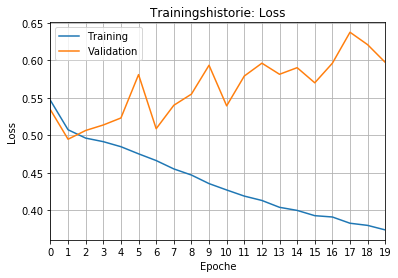

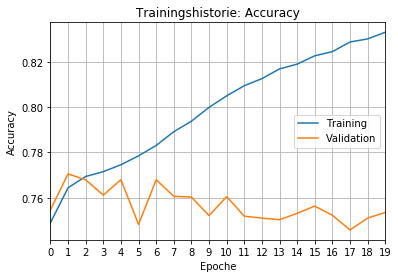

In [44]:
# Plot Modell Historie Loss und Accuracy
plt.figure(4)
plt.title('Trainingshistorie: Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlim(0,19)
plt.grid(True)
plt.savefig("trainingshistorieLossVersuch4_" + experimentNumber + ".png")
plt.xticks(np.arange(0, 19.1, step=1))
plt.figure(1)
plt.title('Trainingshistorie: Accuracy')
plt.xticks()
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='right')
plt.xlim(0,numEpoch-1)
plt.xticks(np.arange(0, 19.1, step=1))
plt.grid(True)
plt.savefig("trainingshistorieAccuracyVersuch4_" + experimentNumber + ".png")
plt.show()

In [15]:
# Läd Testdaten
def testDataLoader(imagePaths, batchSize):
    imagesCount= len(imagePaths)  
    while True:
        batchStart = 0
        batchEnd = batchSize
        while batchStart < imagesCount:
            limit = min(batchEnd, imagesCount)
            x = imageLoader(imagePaths[batchStart:limit])
            yield (x) 
            batchStart += batchSize   
            batchEnd += batchSize

In [70]:
# Läd Modell
modell1 = load_model('ergebnisse_versuch4/modell_versuch4_1')

In [167]:
modell1.evaluate_generator( dataLoader(xTest[4:8], yTest[4:8], 4), steps=1)

[0.26932597160339355, 0.9375]

In [ ]:
# Bei der Verwendung von predict_generator werden die daten gemischt 
validPreds = []
imageList = []
for path in xTest:
    imageList = []   
    img = cv2.imread(path)
    img = np.array(img)
    img = img.astype('float32')
    img /= 255
    imageList.append(img)
    validPreds.append(modell1.predict(np.asarray(imageList)))

In [ ]:
# Konfusionsmatrix
validPredArray = np.argmax(np.vstack(validPreds), axis=1)
yTestMax = np.argmax(yTest,axis=1)
cnfMatrix = confusion_matrix(yTestMax[4:8], validPredArray[4:8])
print(cnfMatrix)
fig, ax = plt.subplots(figsize=(6,6)) 
ax = sns.heatmap(cnfMatrix, fmt="d", cmap=plt.cm.Blues, ax=ax , annot=True)
ax.set_xticklabels(classNames)
ax.set_yticklabels(classNames)
plt.title('Konfusionsmatrix')
plt.ylabel('Wahre Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

In [177]:
validPredArray[5]

3

In [170]:
yTest[4:8]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [181]:
yTest[4]

array([1., 0., 0., 0.])

In [152]:
imageList = []   
img = cv2.imread(xTest[0])
img = np.array(img)
img = img.astype('float32')
img /= 255
imageList.append(img)
modell1.predict(np.asarray(imageList))

array([[0.87134   , 0.10437446, 0.01408345, 0.01020208]], dtype=float32)

In [143]:
np.vstack(validPreds)[4]

array([0.5828721 , 0.26600018, 0.09462278, 0.05650496], dtype=float32)

In [144]:
yTestMax[4]

0

In [156]:
np.argmax(yTest,axis=1)

array([1, 1, 1, ..., 0, 3, 3], dtype=int64)